# Scaling TTI equations from Fletcher et al

In [1]:
# import dependencies
import devito as dv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource

In [38]:
# setting up a grid 
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# creating functions for the two pressure fields
p = dv.TimeFunction(name='p', grid=grid, space_order=8, time_order=2)
q = dv.TimeFunction(name='q', grid=grid, space_order=8, time_order=2)

# defining constants and differential operators
vpx = 3
vpz = 3
vpn = 3
vsz = 2
theta = sp.pi/4
alpha = 1
h1p = sp.sin(theta)**2*p.dx2 + sp.cos(theta)**2*p.dz2 + sp.sin(2*theta)*p.dx.dz
h1q = sp.sin(theta)**2*q.dx2 + sp.cos(theta)**2*q.dz2 + sp.sin(2*theta)*q.dx.dz
h2p = p.laplace - h1p
h2q = q.laplace - h1q
h1pq = h1p - alpha*h1q
h2pq = (1/alpha)*h2p - h2q

# defining equations
eq_p = p.dt2 - vpx**2*h2p - alpha*vpz**2*h1q - vsz**2*h1pq
eq_q = q.dt2 - (vpn**2/alpha)*h2p - vpz**2*h1q + vsz**2*h2pq

# define dt using the cfl condition
vmax = 3
dt = np.amin(grid.spacing)*0.5/vmax

# define a time range for the source term
t0 = 0
tn = 250
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=0.03, npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p.forward, expr=src)
src_q = src.inject(field=q.forward, expr=src)

# defining stencils
stencil_p = dv.Eq(p.forward, dv.solve(eq_p, p.forward))
stencil_q = dv.Eq(q.forward, dv.solve(eq_q, q.forward))

# set up operators
op_p = dv.Operator([stencil_p] + src_p)
op_q = dv.Operator([stencil_q] + src_q)

#op = dv.Operator([stencil_p, stencil_q] + src_p + src_q)
#op(dt=dt)

# call operators
op_p(dt=dt)
op_q(dt=dt)

Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.05 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.04546100000000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=3e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

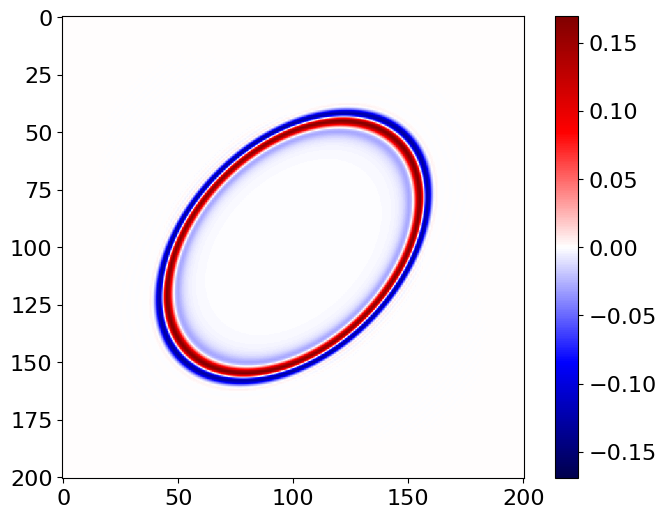

In [39]:
vmax = np.amax(np.abs(p.data[0]))
plt.imshow(p.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()